In [35]:
#import de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [36]:
#carga de datos
df = pd.read_csv('../datos_simulados/datos_final.csv')
df.head()

,Clase,Pieza,Superficie_1,Superficie_2,Tamanio_cavidad_mm,Estado_cavidad,Tecnica,Tipo_resina,Índice_contracción_%,Peso_resina_inicial_mg,Peso_sobrante_mg,Margen_cavo_mm,Ajuste_margen
0,IV,24,Incisal,Mesial,4.27,limpia,Bulk,Compuesta,2.0,129.37,23.65,4.80,Sobreobturado
1,V,17,Bucal,ninguna,4.13,con_tejido,Bulk,Con fibra de vidrio,1.0,103.13,10.48,4.34,Sobreobturado
2,II,16,Mesial,ninguna,5.06,limpia,Estratificacion,Fluida,3.5,148.39,18.02,5.12,Equiobturado
3,IV,24,Incisal,Mesial,3.33,limpia,Bulk,Fluida,3.5,98.47,19.48,4.03,Sobreobturado
4,IV,7,Incisal,Mesial,2.04,con_tejido,Bulk,Bulk,1.5,91.32,1.65,2.16,Sobreobturado


In [37]:
# Variables categóricas
columnas_binarias = ['Estado_cavidad']  # limpia, remanente
columnas_onehot = [
    'Superficie_1',       # Bucal, Lingual, etc.
    'Clase',              # I, II, III, IV, V, VI.
    'Tecnica',            # Bulk, Estratificación
    'Tipo_resina',        # Compuesta, Fluida, etc.
    'Ajuste_margen',      # Sobreobt, Subobt, Equiobt
    'Superficie_2'        # Mesial, Distal, ninguna
]

# Rellenar valores nulos en Superficie_2 con 'ninguna'
df.fillna({'Superficie_2': 'ninguna'}, inplace=True)

# Binarizar 'Estado_cavidad'
df['Estado_cavidad'] = df['Estado_cavidad'].map({
    'limpia': 0,
    'con_tejido': 1
})

# Aplicar OneHotEncoder
df_codificado = pd.get_dummies(df, columns=columnas_onehot, dtype=int)

# Mostrar los primeros registros codificados
df_codificado.head()


,Pieza,Tamanio_cavidad_mm,Estado_cavidad,Índice_contracción_%,Peso_resina_inicial_mg,Peso_sobrante_mg,Margen_cavo_mm,Superficie_1_Bucal,Superficie_1_Distal,Superficie_1_Incisal,...,Tipo_resina_Bulk,Tipo_resina_Compuesta,Tipo_resina_Con fibra de vidrio,Tipo_resina_Fluida,Ajuste_margen_Equiobturado,Ajuste_margen_Sobreobturado,Ajuste_margen_Subobturado,Superficie_2_Distal,Superficie_2_Mesial,Superficie_2_ninguna
0,24,4.27,0,2.0,129.37,23.65,4.80,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,17,4.13,1,1.0,103.13,10.48,4.34,1,0,0,...,0,0,1,0,0,1,0,0,0,1
2,16,5.06,0,3.5,148.39,18.02,5.12,0,0,0,...,0,0,0,1,1,0,0,0,0,1
3,24,3.33,0,3.5,98.47,19.48,4.03,0,0,1,...,0,0,0,1,0,1,0,0,1,0
4,7,2.04,1,1.5,91.32,1.65,2.16,0,0,1,...,1,0,0,0,0,1,0,0,1,0


In [38]:
# Variable objetivo: cuánta resina se debe utilizar
#y = df_codificado['Peso_resina_inicial_mg']

# Variables de entrada: eliminamos columnas que no deben usarse para predecir
#X = df_codificado.drop(columns=['Peso_resina_inicial_mg', 'Peso_sobrante_mg'])
# Crear la nueva variable objetivo: resina realmente utilizada
df_codificado['Resina_utilizada'] = df_codificado['Peso_resina_inicial_mg'] - df_codificado['Peso_sobrante_mg']

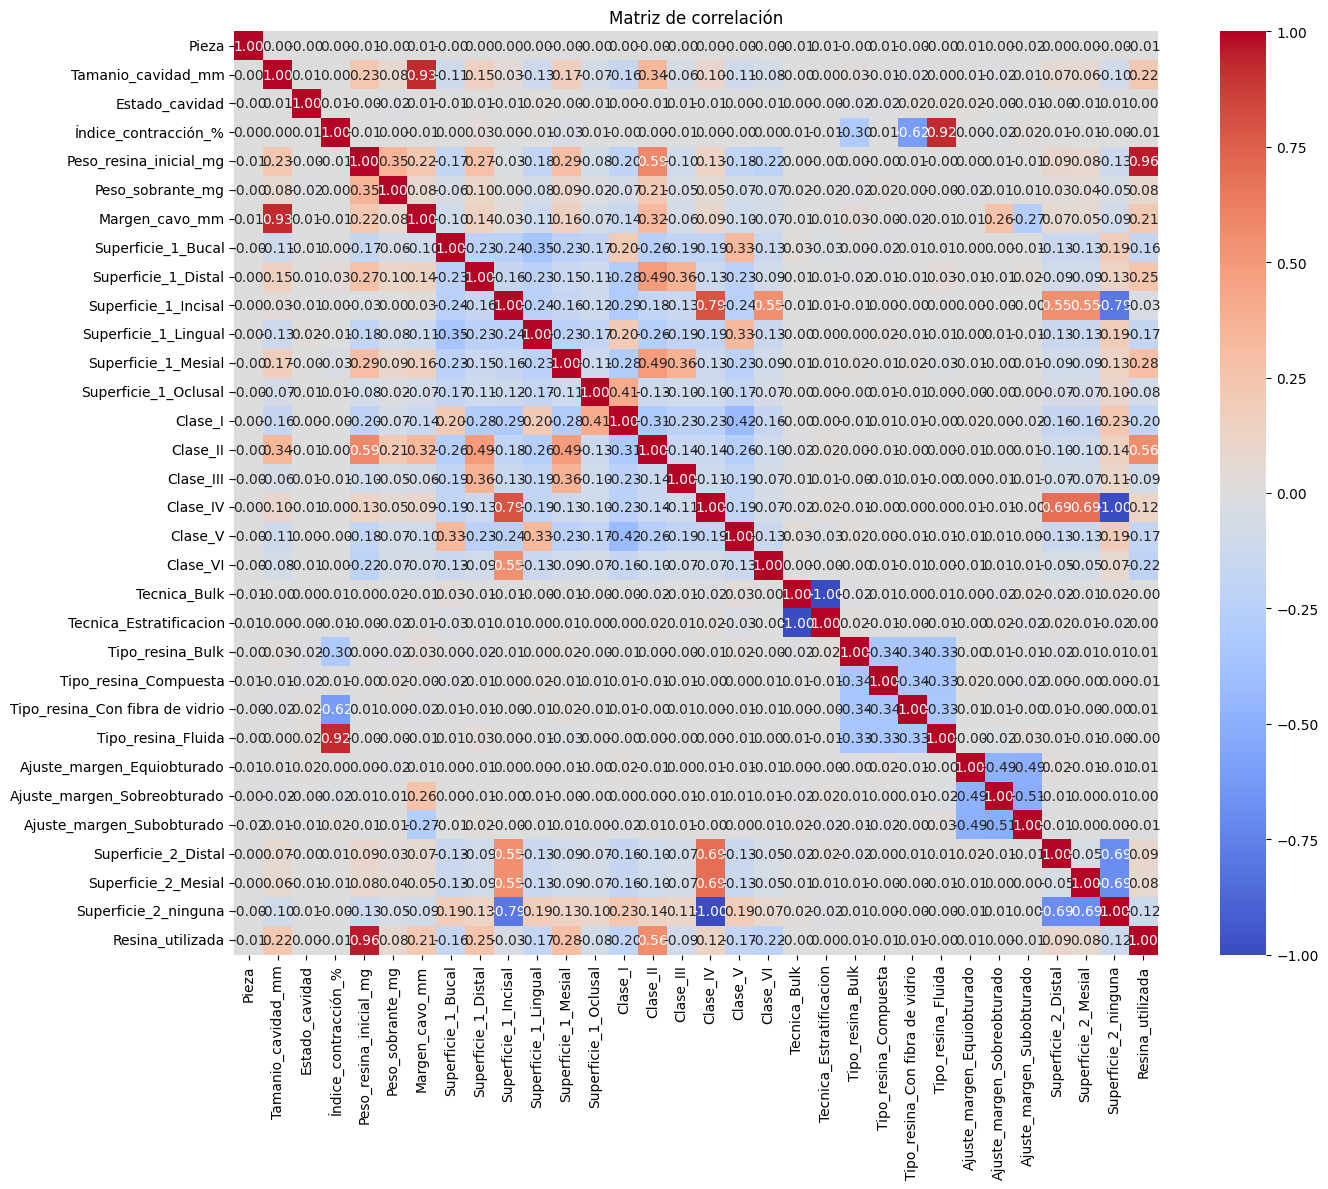

In [39]:
correlacion = df_codificado.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()

In [40]:
# Definir variable objetivo
y = df_codificado['Resina_utilizada']

# Eliminar columnas que no deben usarse para predecir
X = df_codificado.drop(columns=['Peso_resina_inicial_mg', 'Peso_sobrante_mg', 'Resina_utilizada'])

In [41]:
# Dividir los datos en entrenamiento (80%) y prueba (20%)
# test_size=0.2 indica que el 20% de los datos será para prueba
# random_state=42 garantiza que la división siempre sea la misma (para reproducibilidad)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
modelo = DecisionTreeRegressor(random_state=42)
modelo.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [43]:
# Realizar predicciones sobre los datos de prueba
y_pred = modelo.predict(X_test)

# Calcular el RMSE (raíz del error cuadrático medio)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calcular el R² (coeficiente de determinación)
r2 = r2_score(y_test, y_pred)

#métricas de evaluación
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 23.64
R²: -0.37


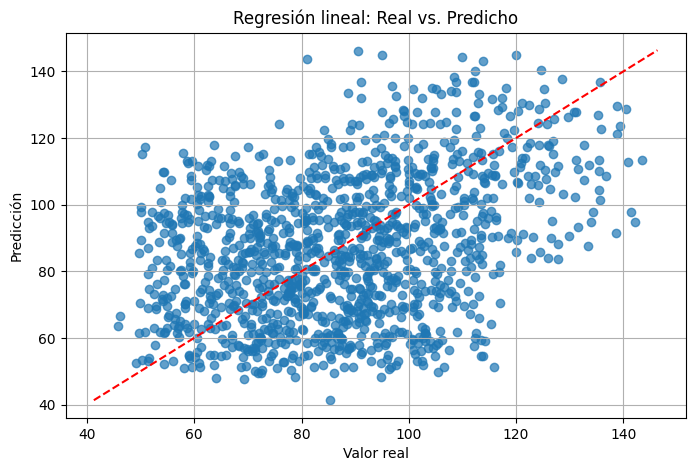

In [44]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Regresión lineal: Real vs. Predicho")
plt.grid(True)
plt.show()


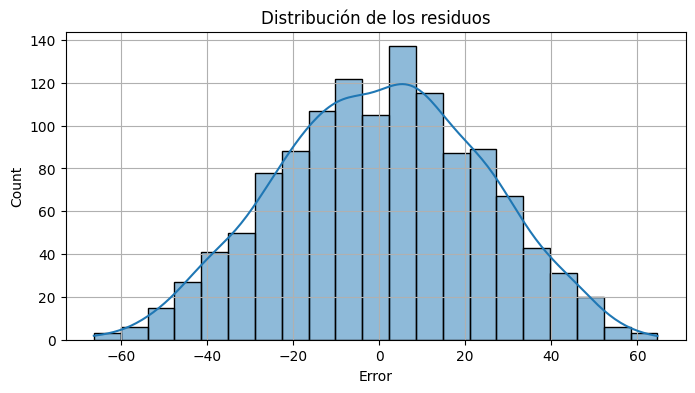

In [45]:
residuos = y_test - y_pred

plt.figure(figsize=(8,4))
sns.histplot(residuos, kde=True)
plt.title("Distribución de los residuos")
plt.xlabel("Error")
plt.grid(True)
plt.show()

In [46]:
#otros modelos
modelo2 = DecisionTreeRegressor(
    max_depth=None,
    min_samples_leaf=1,
    random_state=42
)
modelo2.fit(X_train, y_train)
# Realizar predicciones sobre los datos de prueba
y_pred = modelo2.predict(X_test)

# Calcular el RMSE (raíz del error cuadrático medio)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calcular el R² (coeficiente de determinación)
r2 = r2_score(y_test, y_pred)

#métricas de evaluación
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 23.64
R²: -0.37


In [47]:
modelo3 = DecisionTreeRegressor(
    max_depth=None,
    min_samples_leaf=1,
    random_state=42
)
modelo3.fit(X_train, y_train)
# Realizar predicciones sobre los datos de prueba
y_pred = modelo3.predict(X_test)

# Calcular el RMSE (raíz del error cuadrático medio)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calcular el R² (coeficiente de determinación)
r2 = r2_score(y_test, y_pred)

#métricas de evaluación
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 23.64
R²: -0.37


In [48]:
modelo4 = DecisionTreeRegressor(
    max_depth=None,
    min_samples_leaf=5,
    random_state=42
)
modelo4.fit(X_train, y_train)
# Realizar predicciones sobre los datos de prueba
y_pred = modelo4.predict(X_test)

# Calcular el RMSE (raíz del error cuadrático medio)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calcular el R² (coeficiente de determinación)
r2 = r2_score(y_test, y_pred)

#métricas de evaluación
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 19.51
R²: 0.07


In [65]:
modelo5 = DecisionTreeRegressor(
    max_depth=4,
    min_samples_leaf=3,
    random_state=42
)
modelo5.fit(X_train, y_train)
# Realizar predicciones sobre los datos de prueba
y_pred = modelo5.predict(X_test)

# Calcular el RMSE (raíz del error cuadrático medio)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calcular el R² (coeficiente de determinación)
r2 = r2_score(y_test, y_pred)

#métricas de evaluación
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 15.91
R²: 0.38
